# Tutorial 4: Gaussian Process noise model

**Author:** Hannu Parviainen <br>
**Edited:** 1 November 2024

The previous examples have assumed that the noise in our observations is white, but ExoIris also allows you to model the noise as a Gaussian Process with a freely set kernel. ExoIris uses the Celerite2 package for Gaussian Process calculation. 

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from matplotlib.pyplot import subplots, setp
from multiprocessing import Pool
from exoiris import load_model

## Load a previous analysis

In [4]:
ts = load_model("01a.fits", name='04a')

## Changing the noise model

The noise model used for the analysis can be changed with the `ExoIris.set_noise_model` method that, at the time of writing, accepts two options: `white` or `fixed_gp`. By default, ExoIris assumes white noise, but changing to use `fixed_gp` initialises `celerite2.GaussianProcess` with a Matern-3/2 kernel. The "fixed" in the GP noise model comes from the fact that the GP hyperparameters are not included into the model, but the GP kernel and its hyperparamters are instead considered to be fixed in the analysis. The kernel is given default hyperparameters that should be optimised for the data. The GP can be accessed from `ExoIris.gp`.

So, let's change to use a fixed GP log likelihood, and take a lookg at the `ExoIris.gp`.

In [5]:
ts.set_noise_model('fixed_gp')

In [6]:
ts.gp

In [8]:
ts.gp[0].kernel

In [9]:
ts.gp[0].kernel.sigma, ts.gp[0].kernel.rho

(0.010018713459497456, 0.1)

By default, ExoIris sets up a GP with a Matern-3/2 kernel with sigma corresponding to the standard deviation of the out-of-transit flux, and rho of 0.1. **These hyperparameters are almost certainly a very poor choice to represent the noise in your data and should be changed before continuing to the analysis.**

ExoIris offers two utility functions to modify the kernel and its hyperparameters. First, `ExoIris.set_gp_hyperparameters(sigma, rho)` can be used to quickly set the two Matern-3/2 kernel hyperparameters.

In [12]:
ts.set_gp_hyperparameters(sigma=1e-3, rho=0.1)
print(ts.gp[0].kernel, ts.gp[0].kernel.sigma, ts.gp[0].kernel.rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.sigma, ts.gp[1].kernel.rho)

<celerite2.terms.Matern32Term object at 0x74f6a023a6c0> 0.001 0.1
<celerite2.terms.Matern32Term object at 0x74f6993f8e60> 0.001 0.1


Second, `ExoIris.set_gp_kernel(celerite2.Term)` can be used to set the GP kernel. This is useful if you want to use a more complex kernel than the basic Matern-3/2.

In [14]:
from celerite2.terms import Matern32Term

ts.set_gp_kernel(Matern32Term(sigma=1e-6, rho=0.8) + Matern32Term(sigma=1e-3, rho=1e-4))
print(ts.gp[0].kernel, ts.gp[0].kernel.terms[0].sigma, ts.gp[0].kernel.terms[0].rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.terms[0].sigma, ts.gp[1].kernel.terms[0].rho)

<celerite2.terms.TermSum object at 0x74f698e12c90> 1e-06 0.8
<celerite2.terms.TermSum object at 0x74f698e12c90> 1e-06 0.8


However, the same effect can be achieved by assigning the kernel directly to the `ExoIris.gp.kernel` attribute.

In [15]:
ts.gp[0].kernel = Matern32Term(sigma=1e-6, rho=0.8) + Matern32Term(sigma=1e-3, rho=1e-4)
ts.gp[1].kernel = Matern32Term(sigma=1e-6, rho=0.8) + Matern32Term(sigma=1e-3, rho=1e-4)
print(ts.gp[0].kernel, ts.gp[0].kernel.terms[0].sigma, ts.gp[0].kernel.terms[0].rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.terms[0].sigma, ts.gp[1].kernel.terms[0].rho)

<celerite2.terms.TermSum object at 0x74f698f88e90> 1e-06 0.8
<celerite2.terms.TermSum object at 0x74f698e136e0> 1e-06 0.8


## Optimising Matern-3/2 hyperparameters to the data set

The `ExoIris.optimize_gp_hyperparameters` method can be used to optimise a Matern-3/2 kernel to the out-of-transit data. The method can be used without any arguments, but the optimisation can be fine tuned with optional arguments:

- **log10_sigma_bounds**: Either the bounds for log$_{10}$ sigma as a tuple of two floats or a single float to fix the parameter to the given value.
- **log10_rho_bounds**: Either the bounds for log$_{10}$ rho as a tuple of two floats or a single float to fix the parameter to the given value.
- **log10_sigma_prior**: The prior distribution for log$_{10}$ sigma as an object with a `logpdf` method or as an iterable containing the mean and standard deviation of a normal distribution.
- **log10_rho_prior**: The prior distribution for log$_{10}$ rho as an object with a `logpdf` method or as an iterable containing the mean and standard deviation of a normal distribution. 
- **subset**: The subset used data to use for the optimization. The method uses all the data by default, but a subset can be chosen by either giving a single float specifying the fraction of the spectroscopic light curves to use, or an iterable containing the integer indices of the light curves to use.
- **npop**: The population size for the differential evolution optimiser.
- **niter** : The number of iterations for the differential evolution optimisation process.

**Noe:** the method will overwrite any existing GP kernel with a Matern-3/2 kernel with optimised hyperparameters.

In [16]:
ts.optimize_gp_hyperparameters()

(array([0.00070027, 0.00010177]), 0.16395275051763747)

In [17]:
print(ts.gp[0].kernel, ts.gp[0].kernel.terms[0].sigma, ts.gp[0].kernel.terms[0].rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.terms[0].sigma, ts.gp[1].kernel.terms[0].rho)

<celerite2.terms.Matern32Term object at 0x74f6a0269fa0> 0.0007002665860718246 0.00010177335634191771
<celerite2.terms.Matern32Term object at 0x74f698f8a9c0> 0.0007002665860718246 0.00010177335634191771


## Model optimisation and posterior sampling

Let's first plot the posterior model for the loaded white-noise analysis.

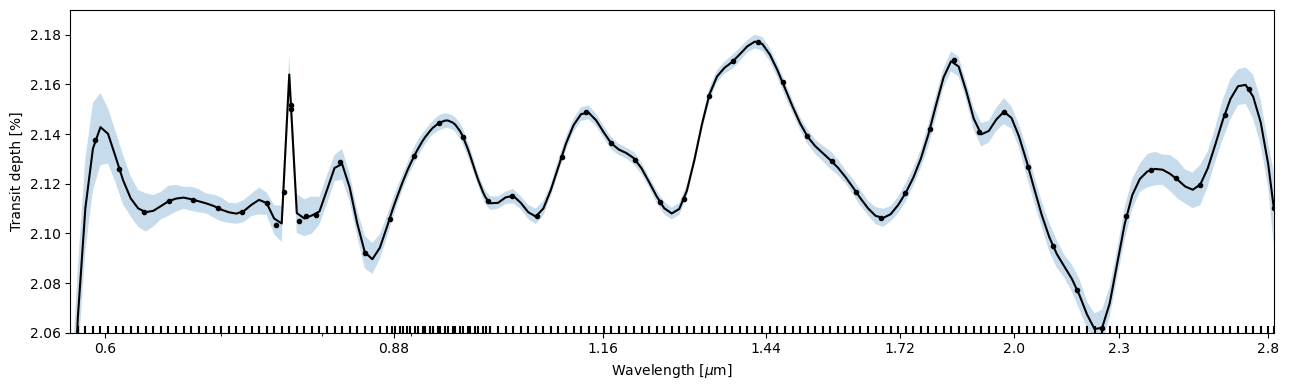

In [18]:
pargs = dict(xscale='log', ylim=(2.06,2.19), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8])

fig, ax = subplots(figsize=(13,4))
ts.plot_transmission_spectrum('mcmc', ax=ax, **pargs);
fig.tight_layout()

Then, we can again do a quick DE optimisation before moving to sample the posterior. In this example, the optimisation finishes immediately because the GP log likelihood is very similar to the white noise assumtion.

In [19]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

In [20]:
pvp0 = ts.create_initial_population(250, 'mcmc', False)

Global optimisation:   0%|          | 0/1500 [00:00<?, ?it/s]

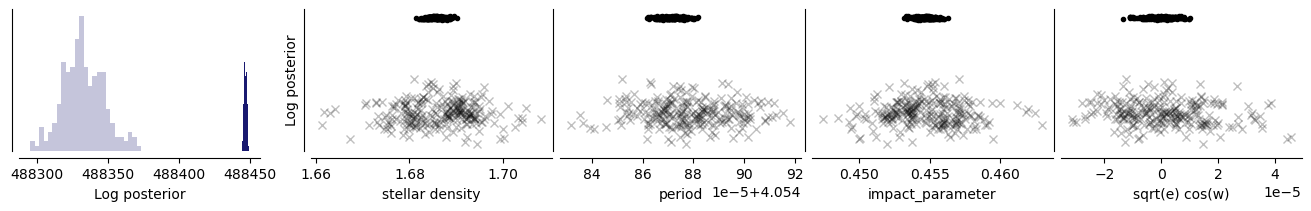

In [23]:
ts.fit(niter=1500, initial_population=pvp0, pool=pool, lnpost=lnpostf)

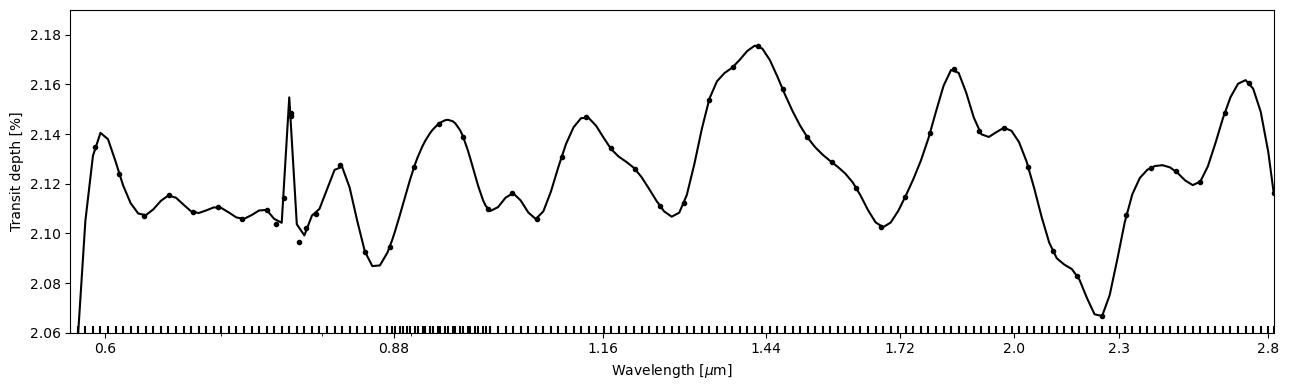

In [25]:
fig, ax = subplots(figsize=(13,4))
ts.plot_transmission_spectrum('fit', ax=ax, **pargs);
fig.tight_layout()

In [26]:
ts.reset_sampler()

In [27]:
ts.sample(1000, thin=100, repeats=2, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/1000 [00:00<?, ?it/s]

And now we can plot the GP posterior model. In this example case, changing the noise model led to slightly larger posterior uncertainties, but the differences aren't great.

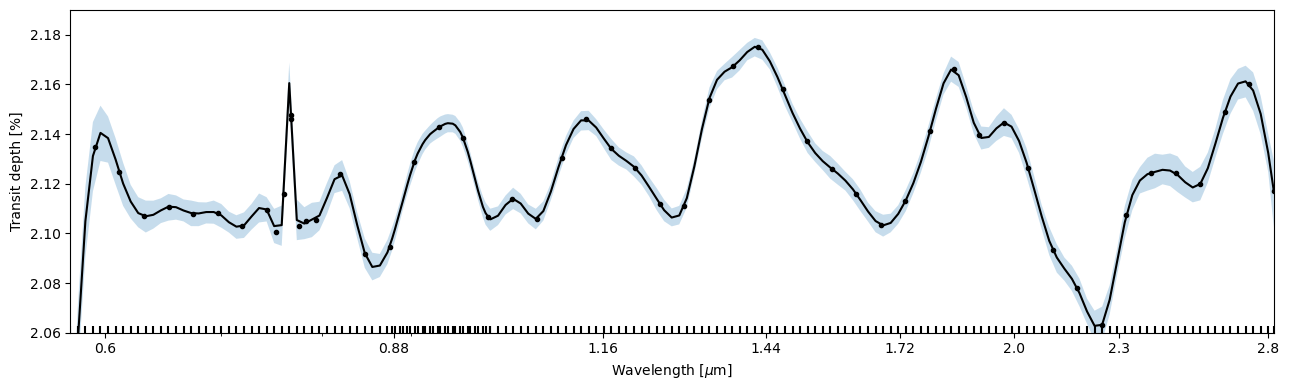

In [28]:
fig, ax = subplots(figsize=(13,4))
ts.plot_transmission_spectrum('mcmc', ax=ax, **pargs);
fig.tight_layout()

In [29]:
ts.save()

---

<center>&copy;2024 Hannu Parviainen</center>